In [1]:
list_classes = ["use_sword", "sword_drawn"]
import random
import numpy as np
import torch
from torch.utils.data.dataset import random_split

# set seeds for reproducibility
SEED = 123
_ = random.seed(SEED)
_ = np.random.seed(SEED)
_ = torch.manual_seed(SEED)

In [2]:
import cv2  # you might need to run `pip install opencv-python`
import os

def get_frames(filename: str, n_frames: int = 16):
    """
    :param filename: path to video file
    :param n_frames: number of frames to extract

    :return: list of frames, number of frames in video
    """
    frames = []
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_list= np.linspace(0, v_len-1, n_frames + 1, dtype=np.int16)
    
    assert len(frame_list) == n_frames + 1  # sanity check

    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            # The variable success is a boolean value that is returned by the cv2.VideoCapture.read function,
            #  which attempts to read the next frame from the video. 
            # - If success is True, it means that the frame was read successfully and the frame variable will contain the 
            #   image data for the next frame of the video. 
            # - If success is False, it means that there are no more frames to read from the video (i.e., we have reached 
            #   the end of the video, should not happen here) or there was an error in reading the frame. 
            # Therefore, the success variable is used in the get_frames function to check if a frame was 
            # successfully read from the video file or not, and if it was not read successfully, 
            # the function continues to the next iteration of the loop to try and read the next frame.
            continue
            # there is usually one frame missing at the end of the video, which is why frame_list is one element longer
        if (fn in frame_list) and (len(frames) < n_frames):
            # when there is no frame missing, the last frame is not added to the list of frames
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()

    if len(frames) < n_frames:
        print(f'Warning: Could not extract all frames from video {filename}')

    return frames, v_len


def store_frames(frames, path2store) -> None:
    """
    :param frames: list of frames
    :param path2store: path to store frames

    :return: None
    """
    for ii, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path2img = os.path.join(path2store, "frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame)

In [3]:
EXTENSIONS = [".avi", ".mkv"]
N_FRAMES = 16

PATH2DATA = "./videos_training"
SUB_FOLDER = "videos"
SUB_FOLDER_JPG = "frames"
PATH2ACATGS = os.path.join(PATH2DATA, SUB_FOLDER)
LIST_OF_CATEGORIES = os.listdir(PATH2ACATGS)
LIST_OF_CATEGORIES, len(LIST_OF_CATEGORIES)

(['sword_drawn', 'use_sword'], 2)

In [4]:
def process_videos():
    for root, dirs, files in os.walk(PATH2ACATGS, topdown=False):
        print(root, dirs)
        for name in files:
            if os.path.splitext(name)[1] not in EXTENSIONS:
                print(f"{name} is not a video file")
                continue
            path2vid = os.path.join(root, name)
            print(path2vid)
            frames, vlen = get_frames(path2vid, n_frames = N_FRAMES)
            path2store = path2vid.replace(SUB_FOLDER, SUB_FOLDER_JPG)
            for extension in EXTENSIONS:
                path2store = path2store.replace(extension, "")
            os.makedirs(path2store, exist_ok = True)
            store_frames(frames, path2store)

process_videos()

./videos_training\videos\sword_drawn []
./videos_training\videos\sword_drawn\19th_Century_Cavalry_Sabre_Draw_draw_sword_u_nm_np1_fr_bad_0.avi
./videos_training\videos\sword_drawn\19th_Century_Cavalry_Sabre_Draw_draw_sword_u_nm_np1_fr_bad_1.avi
./videos_training\videos\sword_drawn\Albion_Mercenary_Draw_Cutting_(From_the_Scabbard)_draw_sword_u_cm_np1_fr_med_0.avi
./videos_training\videos\sword_drawn\Albion_Mercenary_Draw_Cutting_(From_the_Scabbard)_draw_sword_u_cm_np1_fr_med_1.avi
./videos_training\videos\sword_drawn\Albion_Mercenary_Draw_Cutting_(From_the_Scabbard)_draw_sword_u_cm_np1_fr_med_2.avi
./videos_training\videos\sword_drawn\A_point_about_drawing_swords_draw_sword_u_nm_np1_fr_med_0.avi
./videos_training\videos\sword_drawn\A_point_about_drawing_swords_draw_sword_u_nm_np1_fr_med_1.avi
./videos_training\videos\sword_drawn\A_point_about_drawing_swords_draw_sword_u_nm_np1_fr_med_2.avi
./videos_training\videos\sword_drawn\Christian_Martial_Arts_-_Yeshua-Do_Shimmyo_Ken-Ryu_Iai-jutsu_d

In [5]:
import re

# Load the data
def get_vids(path2data = "./frames_training", sub_folder_jpg = "frames"):
    """
    :param path2data: path to data
    :param sub_folder_jpg: subfolder where the frames are stored

    :return: videos (selected frames), list of labels
    """
    X = []
    y = []
    path2aCatgs = os.path.join(path2data, sub_folder_jpg)
    listOfCategories = os.listdir(path2aCatgs)
    for category in listOfCategories:
        category_path = os.path.join(path2aCatgs, category)
        for video in os.listdir(category_path):
            frames = []
            frame_names = os.listdir(os.path.join(category_path, video))
            frame_names.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))
            # otherwise the frames are not in the correct order (e.g. frame0.jpg, frame1.jpg, frame10.jpg, frame11.jpg, frame12.jpg,
            # frame13.jpg, frame14.jpg, frame15.jpg, frame2.jpg, frame3.jpg, frame4.jpg, frame5.jpg, frame6.jpg, frame7.jpg,
            # frame8.jpg, frame9.jpg) which ain't pretty
            for name in frame_names:
                # looping over the frames of the video
                if ".jpg" not in name:
                    continue
                path2img = os.path.join(category_path, video, name)
                img = cv2.imread(path2img)
                # OpenCV uses a default color representation of BGR (Blue, Green, Red) for images,
                # whereas matplotlib expects a color representation of RGB (Red, Green, Blue). 
                # This difference in color representation can cause the colors to appear weird or distorted in the frames.
                # To fix this issue, we can use the cv2.cvtColor() function in OpenCV to convert the color representation
                # of the frames from BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
                frames.append(img)
            if len(frames) != N_FRAMES:
                print(f'Warning: Could not extract all frames from video {video}')
                continue
            X.append(frames)
            y.append(category)
    return X, y

In [6]:
X_train, y_train = get_vids()


In [7]:
y_train = np.array(y_train)
y_train.shape

(230,)

In [8]:
# We cannot transform X into a numpy array because the elements of X are lists of different sizes (frames of different sizes,
# some videos being of better quality than others).
print(len(X_train), len(X_train[0]), len(X_train[0][0]), len(X_train[0][0][0]))  # 99 videos, 16 frames, first video is 240x320
print(len(X_train), len(X_train[5]), len(X_train[5][0]), len(X_train[5][0][0]))  # 99 videos, 16 frames, fifth video is 240x288


230 16 240 320
230 16 240 288


In [9]:
np.max(X_train[10]), np.min(X_train[10])  # the values are integers between 0 and 255, we might want to normalize them, cf. below


(255, 0)

In [10]:
# Draw X_train[5]
import matplotlib.pyplot as plt

def draw_frames(frames, n_frames = 16, n_cols = 4) -> None:
    """
    :param frames: list of frames
    :param n_frames: number of frames to draw
    :param n_cols: number of columns

    :return: None
    """
    fig = plt.figure(figsize=(12, 12))
    for i in range(n_frames):
        ax = fig.add_subplot(4, 4, i+1)
        ax.imshow(frames[i])
        ax.axis('off')
        ax.set_title(f'Frame {i+1}')
    plt.show()

draw_frames(X_train[5])

<Figure size 1200x1200 with 16 Axes>

In [11]:
WIDTH = 112
HEIGHT = 112

In [12]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Custom Compose class to be able to apply the same transformation to all frames in the sequence
class ComposeCustom(transforms.Compose):
    def __init__(self, transforms):
        # No overwrite
        super().__init__(transforms)
    def __call__(self, imgs):
        # Overwrite
        imgs_tr = []
        first: bool = True
        for t in self.transforms:
            if isinstance(t, RandomHorizontalFlipCustom):
                random_nb = torch.rand(1)
                if first:
                    imgs_tr = [t(img, random_nb) for img in imgs]
                    first = False
                else:
                    imgs_tr = [t(img_tr, random_nb) for img_tr in imgs_tr]
            elif isinstance(t, RandomAffineCustom):
                params = t.get_params(t.degrees, t.translate, t.scale, t.shear, (WIDTH, HEIGHT))
                if first:
                    imgs_tr = [t(img, params) for img in imgs]
                    first = False
                else:
                    imgs_tr = [t(img_tr, params) for img_tr in imgs_tr]
            else:
                if first:
                    imgs_tr = [t(img) for img in imgs]
                    first = False
                else:
                    imgs_tr = [t(img_tr) for img_tr in imgs_tr]
        return imgs_tr
# RandomHorizontalFlip needs to be applied consistently to all frames in the sequence
class RandomHorizontalFlipCustom(transforms.RandomHorizontalFlip):
    def __init__(self, p=0.5):
        # No overwrite
        super().__init__(p)
    def forward(self, img, random_nb):
        # Overwrite
        if random_nb < self.p:
            return transforms.functional.hflip(img)
        return img
# RandomAffine needs to be applied consistently to all frames in the sequence
class RandomAffineCustom(transforms.RandomAffine):
    def __init__(self, *args, **kwargs):
        # No overwrite
        super().__init__(*args, **kwargs)
    def forward(self, img, params):
        # Overwrite
        return transforms.functional.affine(img, *params)


class VideoDataset(Dataset):
    def __init__(self, input_, labels, transform=None):
        self.input_ = input_
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.input_)

    def __getitem__(self, idx):
        frames_tr = self.transform(self.input_[idx])  # Apply the same transformation to each frame
        frames_tr = torch.stack(frames_tr)  # Convert the list of transformed frames to a tensor
        # transform labels to tensor
        labels = list_classes.index(self.labels[idx])
        return frames_tr, labels

In [13]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transformer = ComposeCustom(
    [
        transforms.ToTensor(),
        transforms.Resize((WIDTH, HEIGHT), interpolation=transforms.InterpolationMode.BICUBIC),
        RandomHorizontalFlipCustom(p=0.5),
        RandomAffineCustom(degrees=0, translate=(0.1, 0.1)),
        transforms.Normalize(mean, std),
    ]
)

In [14]:
train_ds = VideoDataset(input_ = X_train, labels = y_train, transform = train_transformer)


In [15]:
# Sanity checks
imgs, label = train_ds[5]

assert (len(train_ds) == len(X_train))
assert (imgs.shape == (16, 3, WIDTH, HEIGHT))
assert (isinstance(label, int))

print(label, list_classes[label])
print(imgs.max(), imgs.min())  # Normalization is correct, values are not between 0 and 255 anymore.

1 sword_drawn
tensor(2.8257) tensor(-2.1179)


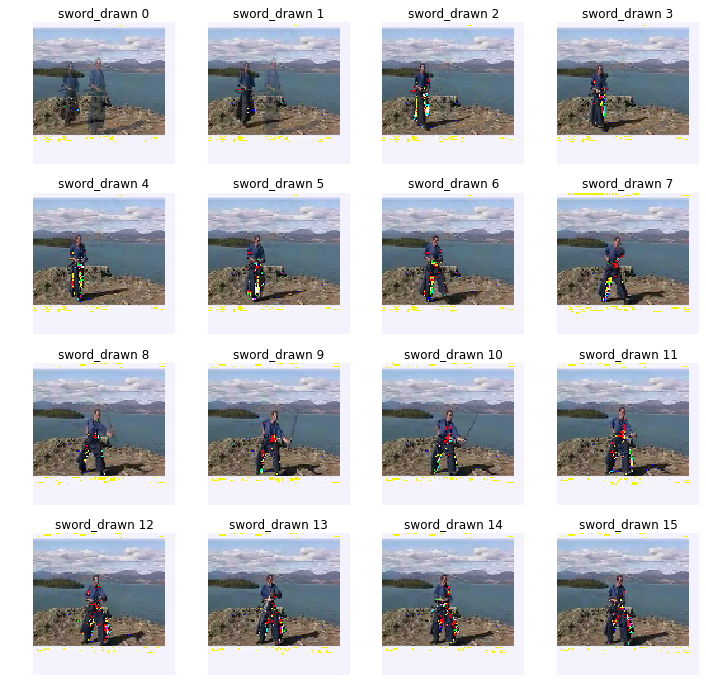

In [16]:
import matplotlib.pylab as plt
from torchvision.transforms.functional import to_pil_image

imgs, label = train_ds[8]

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

plt.figure(figsize=(12, 12))
for ii, img in enumerate(imgs[:]):
    plt.subplot(4, 4, ii+1)
    plt.imshow(denormalize(img, [0.43216, 0.394666, 0.37645], [0.22803, 0.22145, 0.216989]))
    plt.title(list_classes[label] + " " + str(ii))
    plt.axis("off")

In [17]:
len(train_ds)

230

In [18]:
TRAIN_FRACTION = 0.8
TRAIN_SIZE = int(TRAIN_FRACTION*len(train_ds))
TESET_SIZE = len(train_ds)-int(TRAIN_FRACTION*len(train_ds))
train_dataset, test_dataset = random_split(train_ds, [TRAIN_SIZE, TESET_SIZE])

In [19]:
TRAIN_SIZE, TESET_SIZE

(184, 46)

In [20]:
len(test_dataset)

46

In [21]:
def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

In [22]:
# Dataloaders
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_rnn)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn_rnn)
for xb, yb in train_dl:
    print(type(xb), type(yb))  # <class 'torch.Tensor'> <class 'torch.Tensor'>
    print(xb.shape, yb.shape)  # 2, 16, 3, WIDTH, HEIGHT  # 2
    break

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([8, 16, 3, 112, 112]) torch.Size([8])


In [23]:
for xb, yb in test_dl:
    print(type(xb), type(yb))  # <class 'torch.Tensor'> <class 'torch.Tensor'>
    print(xb.shape, yb.shape)  # 2, 16, 3, WIDTH, HEIGHT  # 2
    break

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([8, 16, 3, 112, 112]) torch.Size([8])


In [24]:
len(test_dl)

6

### SecondCNN

In [25]:
from torchvision import models
import torch.nn as nn
from collections import OrderedDict

In [26]:
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x 

In [27]:
params_model={
        "num_classes": 2,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
model = Resnt18Rnn(params_model)      

c:\Users\Thomas\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\Thomas\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
x = torch.zeros(1, 16, 3, 112, 112)
y= model(x)
print(y.argmax(dim=1))

tensor([0])


In [29]:
model

Resnt18Rnn(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

### Train and test

In [30]:
from tqdm.auto import tqdm

In [37]:
# Let's train the model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
num_epochs=5

loss_list = []
list_acc = []
losses_train = np.zeros(num_epochs)
losses_test = np.zeros(num_epochs)
for epoch in range(num_epochs):

    loss_tt, loss_tt_test = 0, 0
    train_acc, test_acc = 0, 0
    pbar_train = tqdm(train_dl)
    model.train()
    for data, target in pbar_train:

        output_train = model(data)

        loss = criterion(output_train, target)
        loss_tt += loss.item()
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        pbar_train.set_description("Training batch loss %s" % loss.item())

        y_pred_class = output_train.argmax(dim=1)
        train_acc += (y_pred_class == target).sum()

    pbar_test = tqdm(test_dl)
    model.eval()
    preds = []
    for data, target in pbar_test:

        output_test = model(data)

        loss = criterion(output_test, target)
        loss_tt_test += loss.item()
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        pbar_test.set_description("Testing batch loss %s" % loss.item())

        y_pred_class = output_test.argmax(dim=1)
        test_acc += (y_pred_class == target).sum()
        preds += y_pred_class.tolist()
        
    losses_train[epoch] = loss_tt / len(train_dl)
    losses_test[epoch] = loss_tt_test / len(test_dl)
    train_acc = train_acc / (8 * len(train_dl))
    test_acc = test_acc / (8 * len(test_dl))


    print(f'Epoch: {epoch+1}/{num_epochs} Loss train: {losses_train[epoch].item() : .3f} Accuracy train: {train_acc*100 : .2f}% Accuracy test : {test_acc * 100 :.2f}%')               


Epoch: 1/5 Loss train:  0.160 Accuracy train:  94.57% Accuracy test : 93.75%


Epoch: 2/5 Loss train:  0.087 Accuracy train:  99.46% Accuracy test : 95.83%


Epoch: 3/5 Loss train:  0.111 Accuracy train:  97.28% Accuracy test : 93.75%


Epoch: 4/5 Loss train:  0.107 Accuracy train:  96.74% Accuracy test : 95.83%


Epoch: 5/5 Loss train:  0.093 Accuracy train:  96.74% Accuracy test : 95.83%


In [38]:
output_test.argmax(dim=1)

tensor([0, 0, 0, 1, 1, 0])

Loss (semilogy):


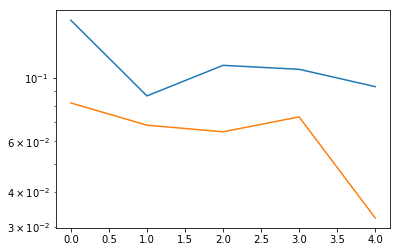

In [39]:
print('Loss (semilogy):')
plt.semilogy(losses_train)
plt.semilogy(losses_test)
plt.show()

In [40]:
# Open the test set
PATH2TESTDATA = "./videos_testing"
SUB_FOLDER = "videos"
SUB_FOLDER_JPG = "frames"
path2vids = os.path.join(PATH2TESTDATA, SUB_FOLDER)

for files in os.listdir(path2vids):
    if os.path.splitext(files)[1] not in EXTENSIONS:
        print(f"{files} is not a video file. Skipping...")
        continue
    path2vid = os.path.join(path2vids, files)
    frames, vlen = get_frames(path2vid, n_frames = N_FRAMES)
    path2store = path2vid.replace(SUB_FOLDER, SUB_FOLDER_JPG)
    for extension in EXTENSIONS:
        path2store = path2store.replace(extension, "")
    os.makedirs(path2store, exist_ok= True)
    store_frames(frames, path2store)

In [41]:
# Load the data
def get_test_vids(path2data = "./frames_testing", sub_folder_jpg = "frames"):
    """
    :param path2data: path to data
    :param sub_folder_jpg: subfolder where the frames are stored

    :return: videos (selected frames), no list of labels (we don't have them, this is the test set), but the names of the videos
    """
    X = []
    vid_names = []
    path2frames = os.path.join(path2data, sub_folder_jpg)
    listofvids = os.listdir(path2frames)
    for video in listofvids:
        # looping over the videos
        vid_names.append(video)
        frames = []
        frame_names = os.listdir(os.path.join(path2frames, video))
        frame_names.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))
        # otherwise the frames are not in the correct order (e.g. frame0.jpg, frame1.jpg, frame10.jpg, frame11.jpg, frame12.jpg,
        # frame13.jpg, frame14.jpg, frame15.jpg, frame2.jpg, frame3.jpg, frame4.jpg, frame5.jpg, frame6.jpg, frame7.jpg,
        # frame8.jpg, frame9.jpg) which ain't pretty
        for name in frame_names:
            # looping over the frames of the video
            if ".jpg" not in name:
                continue
            path2img = os.path.join(path2frames, video, name)
            img = cv2.imread(path2img)
            # OpenCV uses a default color representation of BGR (Blue, Green, Red) for images,
            # whereas PyTorch expects a color representation of RGB (Red, Green, Blue). 
            # This difference in color representation can cause the colors to appear weird or distorted in the frames.
            # To fix this issue, we can use the cv2.cvtColor() function in OpenCV to convert the color representation
            # of the frames from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            frames.append(img)
        if len(frames) != N_FRAMES:
            print(f'Warning: Could not extract all frames from video {video}')
            continue
        X.append(frames)
    return X, vid_names

In [42]:
X_test, vid_names_test = get_test_vids()

len(X_test), len(vid_names_test)

(296, 296)

In [43]:
# Predict the test set
test_transforms = ComposeCustom(
    [transforms.ToTensor(),
        transforms.Resize((WIDTH, HEIGHT), interpolation=transforms.InterpolationMode.BICUBIC),
        RandomHorizontalFlipCustom(p=0.5),
        RandomAffineCustom(degrees=0, translate=(0.1, 0.1)),
        transforms.Normalize(mean, std),]
)

class TestVideoDataset(Dataset):
    def __init__(self, input_, transform=None):
        self.input_ = input_
        self.transform = transform
    
    def __len__(self):
        return len(self.input_)
    
    def __getitem__(self, idx):
        frames_tr = self.transform(self.input_[idx])  # Apply the same transformation to each frame
        frames_tr = torch.stack(frames_tr)  # Convert the list of transformed frames to a tensor
        return frames_tr

test_dataset = TestVideoDataset(X_test, transform=test_transforms)
real_test_dl = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [44]:
len(test_dataset)

296

In [45]:
def predict(model, test_loader):
    model.eval()
    preds = []
    for batch_idx, data in enumerate(test_loader):
        print(f'Predicting batch {batch_idx+1}/{len(test_loader)}')
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        preds += pred.tolist()
    return preds

preds = predict(model, real_test_dl)

Predicting batch 1/148
Predicting batch 2/148
Predicting batch 3/148
Predicting batch 4/148
Predicting batch 5/148
Predicting batch 6/148
Predicting batch 7/148
Predicting batch 8/148
Predicting batch 9/148
Predicting batch 10/148
Predicting batch 11/148
Predicting batch 12/148
Predicting batch 13/148
Predicting batch 14/148
Predicting batch 15/148
Predicting batch 16/148
Predicting batch 17/148
Predicting batch 18/148
Predicting batch 19/148
Predicting batch 20/148
Predicting batch 21/148
Predicting batch 22/148
Predicting batch 23/148
Predicting batch 24/148
Predicting batch 25/148
Predicting batch 26/148
Predicting batch 27/148
Predicting batch 28/148
Predicting batch 29/148
Predicting batch 30/148
Predicting batch 31/148
Predicting batch 32/148
Predicting batch 33/148
Predicting batch 34/148
Predicting batch 35/148
Predicting batch 36/148
Predicting batch 37/148
Predicting batch 38/148
Predicting batch 39/148
Predicting batch 40/148
Predicting batch 41/148
Predicting batch 42/148
P

In [46]:
test = []
for i, pred in enumerate(preds):
    test.append(list_classes[pred[0]])

cpt_use = 0
for x in test:
    if x == "use_sword":
        cpt_use += 1
print(f"nombre de use : {cpt_use}, l'autre {len(test)-cpt_use}")

nombre de use : 160, l'autre 136


In [47]:
# Create the submission file
import pandas as pd

submission = pd.read_csv("./videos_testing/video_categories_sample_submission.csv", index_col=0)
# index_col=0 means that the first column of the csv file is the index, i.e. the video names
for idx, pred in enumerate(preds):
    submission.loc[vid_names_test[idx] + ".avi", "category"] = list_classes[pred[0]]

In [48]:
# Save the submission file
submission.to_csv("submission_1403.csv", index=True)

In [49]:
torch.save(model.state_dict(), "modele_soumission_1403.pth")